# Train KNN

## Initial-Setup

In [1]:
!nvidia-smi

Sun Aug  1 17:59:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cp -r '/content/drive/MyDrive/Similar-Image-Search/model_bit.h5' '/content/'

## Import the necessary modules

In [3]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications import *
import tensorflow_hub as hub

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Fix the random seeds
SEEDS=666

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

## Data Gathering

Importing the Flower Dataset

In [4]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


#### Define the class

In [5]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

#### Count of Training and Validation Samples

In [6]:
print("Number of Training Samples: ",len(train_ds))
print("Number of Validation Samples: ",len(validation_ds))

Number of Training Samples:  3120
Number of Validation Samples:  550


### Visualise the Dataset

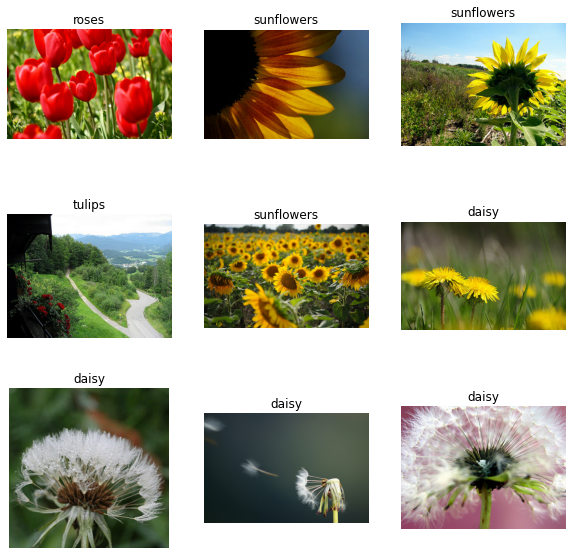

In [7]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[int(label)])
    plt.axis("off")

## Define the Hyperparameters

In [8]:
IMAGE_SIZE = 160
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

## Dataloader

In [9]:
# Image preprocessing utils
def preprocess_test(image, label):
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

## Creating the pipeline for validation sample

In [10]:
validation_ds = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTO)
)

## Load model into KerasLayer

In [11]:
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=False)

## BiT Model

In [12]:
class MyBiTModel(tf.keras.Model):
  def __init__(self, module):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(128)
    self.normalize = Lambda(lambda a: tf.math.l2_normalize(a, axis=1))
    self.bit_model = module
  
  def call(self, images):
    bit_embedding = self.bit_model(images)
    dense1_representations = self.dense1(bit_embedding)
    return self.normalize(dense1_representations)

In [13]:
model = MyBiTModel(module=module)

## Load the weights of the trained BiT Model

In [ ]:
model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))
model.load_weights("model_bit.h5")

### Checking the Validation Pipeline

In [14]:
images, labels = next(iter(validation_ds.take(1)))
print(images.shape, labels.shape)

(64, 160, 160, 3) (64,)


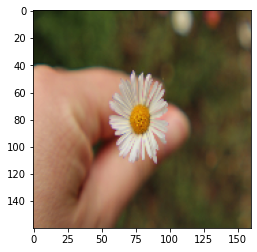

In [15]:
random_index = int(np.random.choice(images.shape[0], 1))
plt.imshow(images[random_index])
plt.show()

## Train a Nearest Neighbors' Model

Determining out nearest neighbors for the features of our query image

In [16]:
validation_features = model.predict(images)
start = time.time()
neighbors = NearestNeighbors(n_neighbors=5,
    algorithm='brute',
    metric='euclidean').fit(validation_features)
print('Time taken: {:.5f} secs'.format(time.time() - start))

Time taken: 0.00043 secs


### Determine the neighbors nearest to our query image

In [17]:
distances, indices = neighbors.kneighbors([validation_features[random_index]])
for i in range(5):
    print(distances[0][i])

0.0
0.26401412
0.28624812
0.3056747
0.3172023


### Visualize a neighbor

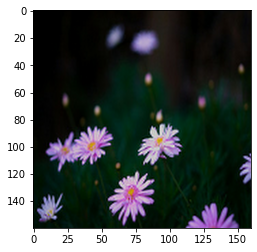

In [18]:
plt.imshow(images[indices[0][1]], interpolation='lanczos')
plt.show()

## Visualizing the nearest neighbors on images

In [19]:
def plot_images(images, labels, distances):
    plt.figure(figsize=(20, 10))
    columns = 4
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(CLASSES[labels[i]]))
        else:
            ax.set_title("Similar Image # " + str(i) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))) + 
                         "\nLabel: {}".format(CLASSES[labels[i]]))
        plt.imshow(image)

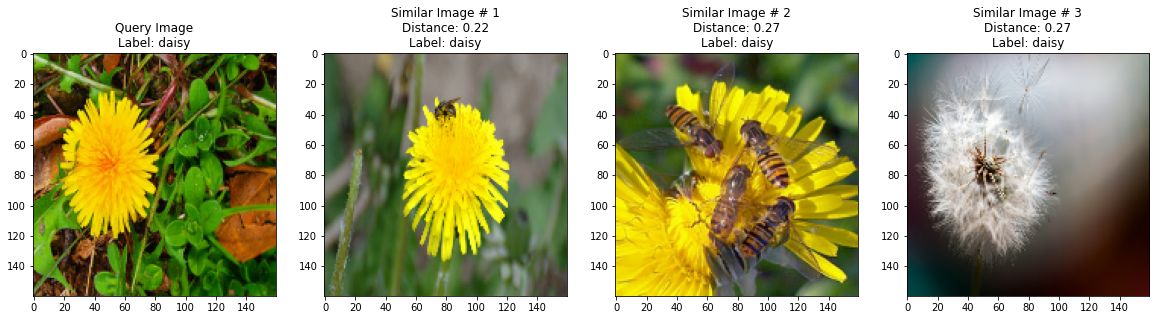

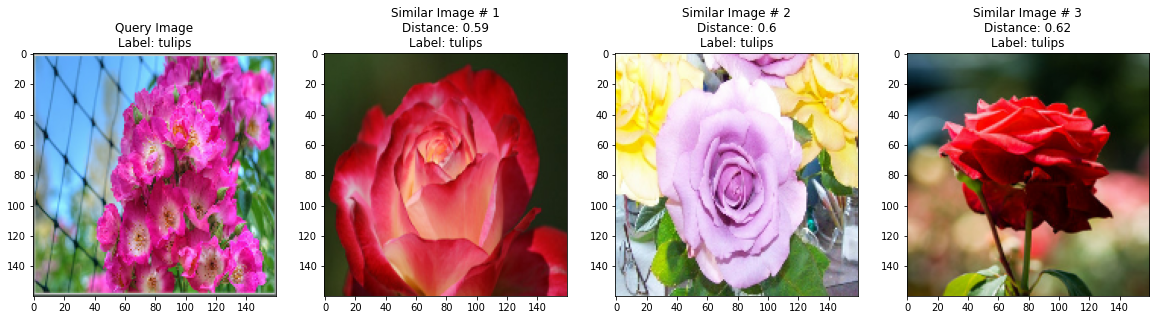

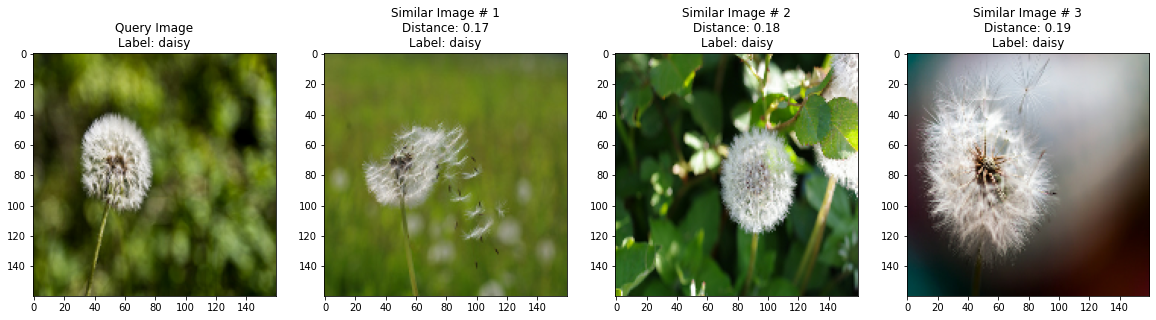

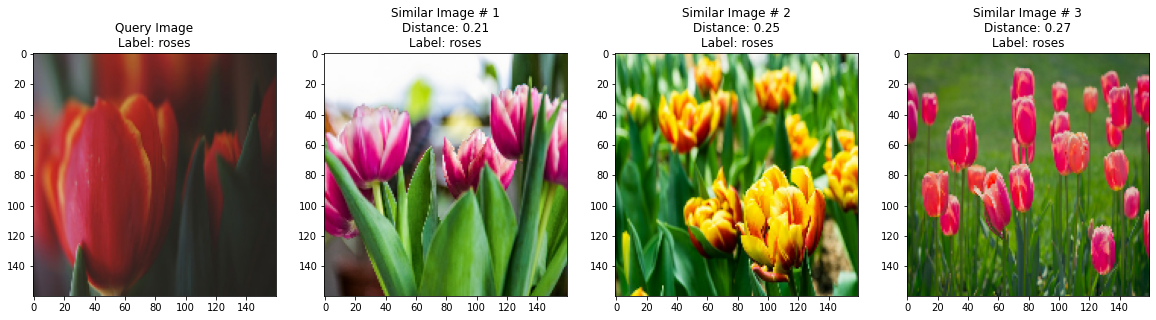

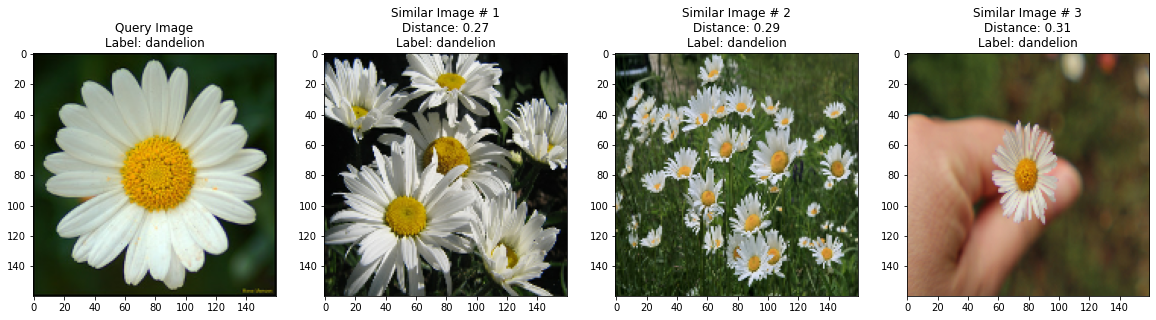

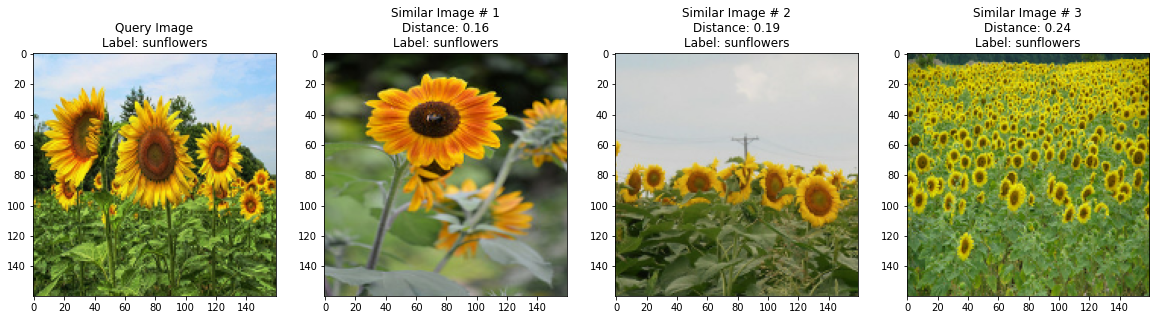

In [20]:
for i in range(6):
    random_index = int(np.random.choice(images.shape[0], 1))
    distances, indices = neighbors.kneighbors(
        [validation_features[random_index]])
    
    # Don't take the first closest image as it will be the same image
    similar_images = [images[random_index]] + \
        [images[indices[0][i]] for i in range(1, 4)]
    similar_labels = [labels[random_index]] + \
        [labels[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_images, similar_labels, distances[0])

## Visualizing the embedding space for the current validation batch

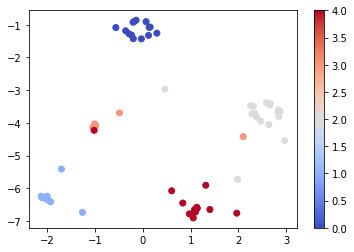

In [21]:
tsne_results = TSNE(n_components=2).fit_transform(validation_features)

color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()

## Visualizing the embedding space for the entire validation pipeline

In [22]:
validation_labels = [label
    for _, labels in validation_ds for label in labels
]
print(len(validation_labels))

550


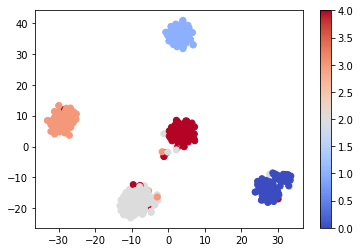

In [23]:
validation_features = model.predict(validation_ds)

tsne_results = TSNE(n_components=2).fit_transform(validation_features)

color_map = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:, 0],
                           tsne_results[:, 1],
                           c=validation_labels,
                           cmap=color_map)
plt.colorbar(scatter_plot)
plt.show()